In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.io import netcdf

import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt

import os
import logging

import numpy as np

import pickle
from pathlib import Path
from cartopy.util import add_cyclic_point
logger = logging.getLogger(__name__)


In [8]:
def main():

    make_maps=False
    region=0
    var1='cLitter'
    var2='cProduct'
    
    SCENARIO_TITLES = ['agtoaff','nattoaff']
    PLOT_TITLES = ['Afforestation on ag land', 'Afforestation on natural land'] 

    ssp, esm = get_scenarios()
    nclim = len(esm)
    years = np.arange(2015,2101)   
    nyears = len(years)
    
    # First get the no land use change data
    csoil_noluc,csoil_noluc_tr,csoil_noluc_te = retrieve_data_generic(var2,'noluc','orchidee')
    cveg_noluc,cveg_noluc_tr,cveg_noluc_te = retrieve_data_generic(var1,'noluc','orchidee')
                 
    if make_maps == True:
        map_diff('cSoil',ssp,esm,SCENARIO_TITLES,PLOT_TITLES)
        map_diff('cVeg',ssp,esm,SCENARIO_TITLES,PLOT_TITLES)
        
    #PLOT THE NO LUC SCENARIO
    scenario_title = 'noluc'
    plot_title = 'orchidee No LUC'
    
    fig,axes=plt.subplots(3,1, figsize=[8,11])


    region_title=['Global','Tropics','NH-Temperate']
    # top left: cveg
    ax=axes[0]
    ax.set_ylabel(r'$\Delta$' +var1+' (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 
    
    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')
    for i1 in range(0,2):
        for i0 in range(0,nclim): 
            if region==0:
                plot_cveg = cveg_noluc[ssp[i1]][esm[i0]]
            elif region==1:
                plot_cveg = cveg_noluc_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_cveg = cveg_noluc_te[ssp[i1]][esm[i0]]               
            ax.plot(years, plot_cveg[0]-plot_cveg[0][0], label=ssp[i1]+' '+esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2) 
            
    # top right: csoil
    ax=axes[1]
    ax.set_ylabel(r'$\Delta$' +var2+' (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_noluc[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_noluc_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_noluc_te[ssp[i1]][esm[i0]]  

            ax.plot(years, plot_csoil[0]-plot_csoil[0][0], label=ssp[i1]+' '+esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2)

    
    # bottom left: ctot
    ax=axes[2]
    ax.set_ylabel(r'$\Delta$' 'Ctot (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_noluc[ssp[i1]][esm[i0]]
                plot_cveg = cveg_noluc[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_noluc_tr[ssp[i1]][esm[i0]]
                plot_cveg = cveg_noluc_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_noluc_te[ssp[i1]][esm[i0]]
                plot_cveg = cveg_noluc_te[ssp[i1]][esm[i0]]
            plotdata = (plot_csoil[0]-plot_csoil[0][0]) + (plot_cveg[0]-plot_cveg[0][0])
            ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)


    handles,labels = axes[0].get_legend_handles_labels()
    fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
    if var1=='cVeg':
        plt.savefig('figures/orchidee/orchidee_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
    else:
        plt.savefig('figures/orchidee/orchidee_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    

#NOW GET THE LAND USE SCENARIOS AND PLOT EITHER THE DIFFERENCES OR THE RAW VALUES

    plot_diff = True
    for i2 in range(0,2):
        scenario_title = SCENARIO_TITLES[i2]
        plot_title = PLOT_TITLES[i2]
        
        csoil,csoil_tr,csoil_te = retrieve_data_generic(var2,scenario_title,'orchidee')
        cveg,cveg_tr,cveg_te = retrieve_data_generic(var1,scenario_title,'orchidee')
        
        fig,axes=plt.subplots(3,1, figsize=[8,11])


        # top left: cveg
        ax=axes[0]
        ax.set_ylabel(r'$\Delta$' +var1+' (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('orchidee ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('orchidee '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        
        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_cveg = cveg[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                if region==1:
                    plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                if region==2:
                    plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]

                if plot_diff==True:
                    ax.plot(years, 
                             (plot_cveg[0]-plot_cveg[0][0]) - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0]), 
                             label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), 
                         label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                   
        
        # top right: csoil
        ax=axes[1]
        ax.set_ylabel(r'$\Delta$' +var2+' (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('orchidee ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('orchidee '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_csoil = csoil[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                
                if plot_diff==True:
                    ax.plot(years, 
                             (plot_csoil[0]-plot_csoil[0][0]) - (plot_csoil_noluc[0]-plot_csoil_noluc[0][0]), 
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax.plot(years, (plot_csoil[0]-plot_csoil[0][0]), 
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                    
        # bottom left: ctot
        ax=axes[2]
        ax.set_ylabel(r'$\Delta$' 'Ctot (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('orchidee ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('orchidee '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        
        for i0 in range(0,nclim):
            for i1 in range(0,2):    
                if region==0:
                    plot_csoil = csoil[ssp[i1]][esm[i0]]
                    plot_cveg = cveg[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:              
                    plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]
                
                if plot_diff==True:
                    plotdata = (plot_csoil[0]-plot_csoil[0][0]) \
                    - (plot_csoil_noluc[0]-plot_csoil_noluc[0][0]) \
                    + (plot_cveg[0]-plot_cveg[0][0]) \
                    - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0])
           
                else:
                    plotdata = (plot_csoil[0]-plot_csoil[0][0]) \
                    + (plot_cveg[0]-plot_cveg[0][0])

                ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)


        handles,labels = axes[0].get_legend_handles_labels()
        fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
        if var1=='cVeg':
            if plot_diff==True:
               plt.savefig('figures/orchidee/orchidee_cpoolsdiff_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
            else:
                plt.savefig('figures/orchidee/orchidee_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
        else:
           if plot_diff==True:
               plt.savefig('figures/orchidee/orchidee_cpoolsdiffV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
           else:
                plt.savefig('figures/orchidee/orchidee_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
              
        #plt.show()


In [9]:
run plot_tools.ipynb

/bdd/ESM2025/WP10/analysis/files/orchidee_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/orchidee_cLitter_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/orchidee_cProduct_agtoaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/orchidee_cLitter_agtoaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/orchidee_cProduct_nattoaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/orchidee_cLitter_nattoaff.pkl
read pickle files


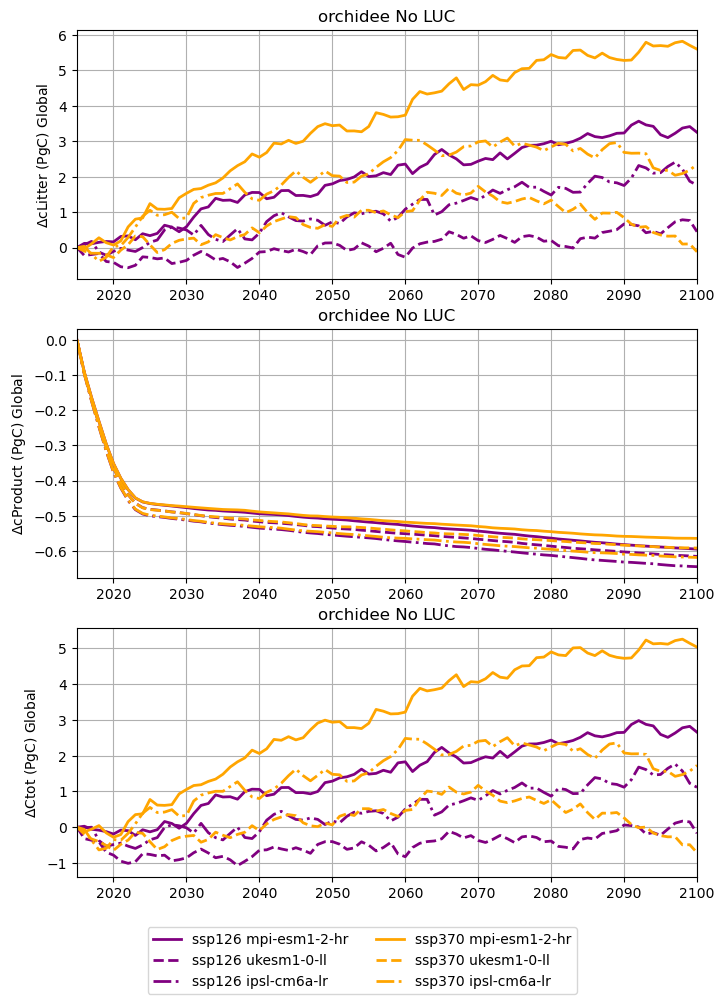

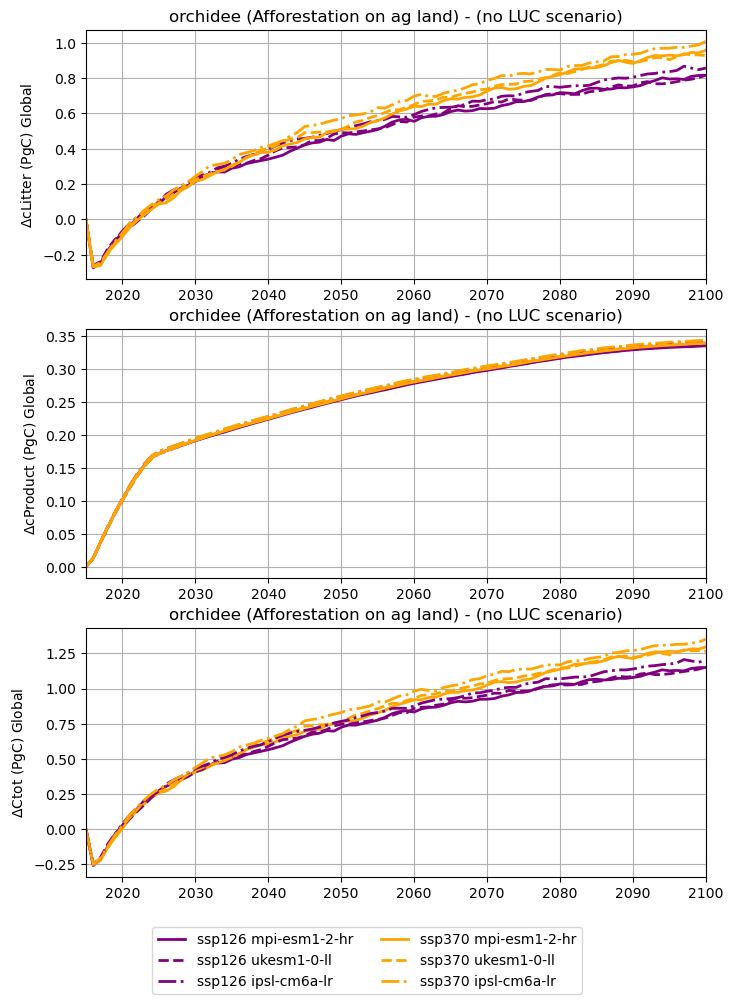

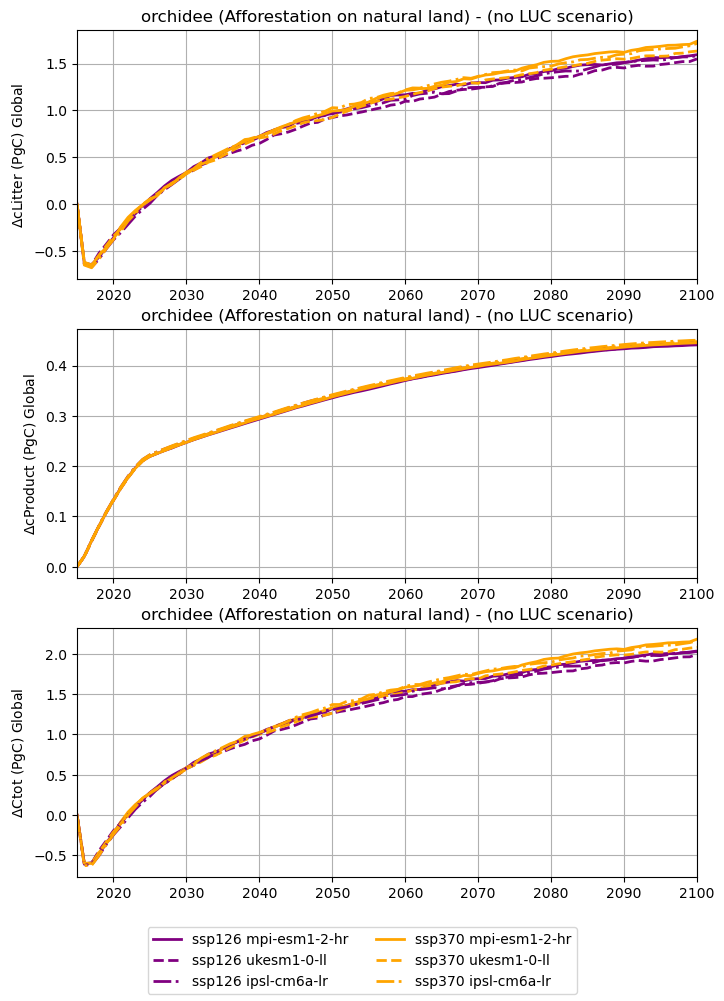

In [10]:
if __name__ == "__main__":
    main()